# Download data and process interferogram stack
George Brencher

## Create and configure environment

In [1]:
import os
if not os.path.exists('/srv/conda/envs/isce2'):
    !mamba create -n isce2 --file https://github.com/UW-GDA/Friendly-InSAR-time-series/blob/main/conda-linux-64.lock
    !conda activate isce2
    !python -m ipykernel install --user --name=isce2

In [ ]:
# Note--if processing on headless server, need to run the following for the stack processor to work: 
# pip install opencv-python-headless

Make sure kernel is set to 'isce2' or 'Python [conda env:isce2]'

'topStack' is a Sentinel 1 interferogram stack processing workflow which has been contributed to isce. To get access to topsStack, which does not come with the conda install of isce, we need to clone isce2 from github. 

In [2]:
#!git clone https://github.com/isce-framework/isce2.git

In [3]:
import isce

# Set Environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

# Set path to topsStack workflow in isce source directory
CWD = os.getcwd()
os.environ['PATH']+=f':{CWD}/isce2/contrib/stack/topsStack'
print(os.environ['PATH'])

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
/srv/conda/envs/isce2/bin:/srv/conda/condabin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/bin:/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications:/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack


In [4]:
# Make sure stack processing scripts are in path
!which stackSentinel.py

/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack/stackSentinel.py


In [38]:
# Do downloads and processing in a temporary folder to avoid clogging the disk
os.chdir('/tmp')
os.makedirs('orbital')
os.makedirs('SLC')
os.makedirs('DEM')
os.makedirs('AUX')

FileExistsError: [Errno 17] File exists: 'orbital'

## Download scenes

In [6]:
#check disk space prior to downloading SLCs
!df -h ~

Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd         15G  206M   15G   2% /home/jovyan


In [32]:
os.chdir('/tmp/SLC')

In [7]:
import getpass
import asf_search as asf
import logging

# Update this with your NASA Earthdata login to download SLC data
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

# prevent DEBUG messages
logging.getLogger("urllib3").setLevel(logging.WARNING)

try:
    user_pass_session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

 ········


Success!


In [8]:
# Create a persistent .netrc file for downloading NASA datasets (ISCE retrieves SRTM by default)
# https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget
!echo "machine urs.earthdata.nasa.gov login {EARTHDATA_LOGIN} password {EARTHDATA_PASSWORD}" > ~/.netrc
!chmod 0600 ~/.netrc

In [9]:
# Set area of interest with two corner points of a box [lat, lon]

# southwestern corner
lower_left = [27.875165, 86.892988]

# northeastern corner
upper_right = [27.918111, 86.949540]

aoi = f'POLYGON(({lower_left[1]} {lower_left[0]}, {lower_left[1]} {upper_right[0]}, {upper_right[1]} {upper_right[0]}, {upper_right[1]} {lower_left[0]}, {lower_left[1]} {lower_left[0]}))'

In [10]:
# Set platform, start and end dates, flight direction, and processing level
opts = {'platform': asf.PLATFORM.SENTINEL1, 
        'start': '2021-08-01T00:00:00Z', 
        'end': '2021-09-01T00:00:00Z', 
        'flightDirection': 'A',
        'processingLevel': 'SLC',
        'frame': 84}

In [11]:
# search for scenes
results = asf.geo_search(intersectsWith=aoi, **opts)
print(f'{len(results)} scenes found')

3 scenes found


In [12]:
# Download scenes
%%time 

#Each scene is ~4 GB
results.download(path = '/tmp', session=user_pass_session)

UsageError: Line magic function `%%time` not found.


In [33]:
# Create a list of zipped SLCs. Assume there are no other files with .zip extension in tmp/SLC
from os import listdir

tmp = listdir('/tmp/SLC')

scenes = []
for file in tmp:
    if file[-4:]=='.zip':
        scenes.append(file[:-4])
        
print(scenes)

['S1A_IW_SLC__1SDV_20210830T121356_20210830T121423_039459_04A972_A57E', 'S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5', 'S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0']


## Download precise orbitals 

In [29]:
os.chdir('/tmp/orbital')

In [14]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

--2022-03-05 18:49:04--  https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5054 (4.9K) [text/plain]
Saving to: ‘fetchOrbit.py’

     0K ....                                                  100% 51.8M=0s

2022-03-05 18:49:04 (51.8 MB/s) - ‘fetchOrbit.py’ saved [5054/5054]



In [15]:
for file in scenes:
    os.system(f'./fetchOrbit.py -i {file}')

Reference time:  2021-08-30 12:14:23
Satellite name:  S1A
Reference time:  2021-08-18 12:14:22
Satellite name:  S1A
Reference time:  2021-08-06 12:14:21
Satellite name:  S1A


### Also download calibration auxliary file
A calibration auxliary (AUX_CAL) file is used for antenna pattern correction to compensate the range phase offset of SAFE products with IPF verison 002.36 (mainly for images acquired before March 2015). 

In [39]:
os.chdir('/tmp/AUX')
!wget https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ

--2022-03-05 19:24:40--  https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ
Resolving qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)... 20.74.8.22
Connecting to qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)|20.74.8.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494159 (483K)
Saving to: ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’

S1A_AUX_CAL_V201409 100%[===================>] 482.58K  --.-KB/s    in 0.04s   

2022-03-05 19:24:40 (10.6 MB/s) - ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’ saved [494159/494159]



## Specify or download digital elevation file

In [35]:
os.chdir('/tmp/DEM')

In [16]:
!which dem.py

/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications/dem.py


In [41]:
print(f'lower left (southwest): {lower_left}, upper right (northwest): {upper_right}')

lower left (southwest): [27.875165, 86.892988], upper right (northwest): [27.918111, 86.94954]


In [37]:
# feed dem.py ingeter coordinates surrounding the aoi, using the following structure: lower lat, upper lat, left lon, right lon 

!dem.py -a stitch -b 27 28 86 87 -r -s 1 -c
!rm demLat*.dem demLat*.dem.xml demLat*.dem.vrt

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N27E086.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   267  100   267    0     0   1091      0 --:--:-- --:--:-- --:--:--  1094
100 18.1M  100 18.1M    0     0   744k      0  0:00:25  0:00:25 --:--:-- 5529k
API open (R): ./demLat_N27_N28_Lon_E086_E087.dem
API close:  ./demLat_N27_N28_Lon_E086_E087.dem
Writing geo

## Stack processing 

In [46]:
os.chdir('/tmp')

In [22]:
# Look at options for stack processing

!stackSentinel.py -h

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: stackSentinel.py [-h] [-H] -s SLC_DIRNAME -o ORBIT_DIRNAME -a
                        AUX_DIRNAME [-w WORK_DIR] -d DEM [-m REFERENCE_DATE]
                        [-c NUM_CONNECTIONS] [-n SWATH_NUM] [-b BBOX]
                        [-t TEXT_CMD] [-x EXCLUDE_DATES] [-i INCLUDE_DATES]
                        [--start_date STARTDATE] [--stop_date STOPDATE]
                        [-z AZIMUTHLOOKS] [-r RANGELOOKS] [-f FILTSTRENGTH]
                        [--snr_misreg_threshold SNRTHRESHOLD]
                        [-p POLARIZATION] [-C {geometry,NESD}]
              

In [50]:
!stackSentinel.py -s /tmp/SLC/ -o /tmp/orbital/ -a /tmp/AUX/ -d /tmp/DEM/demLat_N27_N28_Lon_E086_E087.dem.wgs84 -r 9 -z 2 -c 2 --bbox '27 28 86 87' -f 0.2

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Number of SAFE files found: 3
Number of SAFE files to be used (cover BBOX): 3
*****************************************
Number of dates : 3
List of dates : 
['20210806', '20210818', '20210830']
date      south      north
20210806 26.30085 28.33621
20210818 26.301233 28.336365
20210830 26.300856 28.336529
*****************************************
The overlap region among all dates (based on the preview kml files):
 South   North   East  West 
26.301233 28.33621 86.205772 89.061569
*****************************************
All dates (3)
['20210806', '20210818', '20210830']



In [70]:
os.chdir('/tmp/run_files')

In [71]:
%%time
# First run took 42 min
!sh run_01_unpack_topo_reference

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/run_files/reference', '--auxdir', '/tmp/AUX', '--bbox', '27 28 86 87', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.zip/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.SAFE/annotation/s1a-iw1-slc-v

In [72]:
%%time
!sh run_02_unpack_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/run_files/secondarys/20210818', '--auxdir', '/tmp/AUX', '--bbox', '27 28 86 87', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.zip/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.SAFE/annotation/s1a-iw1-slc-vv-20

In [73]:
%%time
!sh run_03_average_baseline

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: computeBaseline
['--reference', '/tmp/run_files/reference/', '--secondary', '/tmp/run_files/secondarys/20210818', '--baseline_file', '/tmp/run_files/baselines/20210806_20210818/20210806_20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Poly

In [74]:
%%time
!sh run_04_extract_burst_overlaps

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Overlap 0 start time - IW-1 2021-08-06 12:14:05.069835 subset
Overlap 0 stop time - IW-1 2021-08-06 12:14:05.384335 subset
Overlap 0 number of lines - IW-1 154 subset
Overlap 0 number of valid lines - IW-1 117 subset
Top:  ['/tmp/run_files/reference/overlap/IW1/burst_top_01_02.slc']
Bottom:  ['/tmp/run_files/reference/overlap/IW1/burst_bot_01_02.slc']
Overlap 1 start time - IW-1 2021-08-06 12:14:07.828391 subset
Overlap 1 stop time - IW-1 2021-08-06 12:14:08.140836 subset
Overlap 1 number of lines - IW-1 153 subset
Overlap 1 number of valid lines - IW-1 117 subset
Top:  ['

In [75]:
%%time
# First run took 2 min
!sh run_05_overlap_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/run_files/secondarys/20210818', '--reference', '/tmp/run_files/reference', '--geom_referenceDir', '/tmp/run_files/geom_reference', '--coregSLCdir', '/tmp/run_files/coreg_secondarys/20210818', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Additional time offset applied in geo2rdr: 0.0 secs
Additional range offset applied in geo2rdr: 0.0 m
Turning off bistatic delay correction term b

In [76]:
%%time
# First run took 8 min
!sh run_06_overlap_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/run_files/secondarys/20210818', '--reference', '/tmp/run_files/reference', '--coregdir', '/tmp/run_files/coreg_secondarys/20210818', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: -1}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000033
Polynomial Order: 5 - by - 3 
13231.9	-694.453	37.0086	1.12534	
-51368.8	2612.67	-126.264	-4.09993	
49855.9	-2454.85	105.774	3.6755	


In [77]:
%%time
# First run took 13 min
!sh run_07_pairs_misreg

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2', 'Function-3', 'Function-4']
Running: generateIgram
['--reference', '/tmp/run_files/reference', '--secondary', '/tmp/run_files/coreg_secondarys/20210818', '--interferogram', '/tmp/run_files/coarse_interferograms/20210806_20210818', '--interferogram_prefix', 'int', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 6
minReference,maxReference 1 6
minBurst, maxBurst:  1 6
matching burst numbers:  1 1
multiply
read
No range offsets provided
rdict:  {'rangeOff1': '/tmp/run_files/reference/over

In [78]:
%%time
!sh run_08_timeseries_misreg


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 0.0005158476997166879 pixels

Estimated offsets with respect to the stack reference date

20210806 : 0.0
20210818 : -0.003972111997918129
20210830 : 0.0008550393458831261


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 0.012133136014142341 pixels

Estimated offsets with respect to the stack reference date

20210806 : 0.0
20210818 : 0.13346449714995337
20210830 : -0.02426627220908245

CPU times: user 21.3 ms, sys: 10.5 ms, total: 31.8 ms
Wall time: 1.27 s


In [79]:
%%time
# First run took 13 min
!sh run_09_fullBurst_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/run_files/secondarys/20210818', '--reference', '/tmp/run_files/reference', '--geom_referenceDir', '/tmp/run_files/geom_reference', '--coregSLCdir', '/tmp/run_files/coreg_secondarys/20210818', '--azimuth_misreg', '/tmp/run_files/misreg/azimuth/dates/20210818.txt', '--range_misreg', '/tmp/run_files/misreg/range/dates/20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Burst 0 of referenc

In [80]:
%%time
# First run took 9 min
!sh run_10_fullBurst_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/run_files/secondarys/20210818', '--reference', '/tmp/run_files/reference', '--coregdir', '/tmp/run_files/coreg_secondarys/20210818', '--azimuth_misreg', '/tmp/run_files/misreg/azimuth/dates/20210818.txt', '--range_misreg', '/tmp/run_files/misreg/range/dates/20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: -1}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000033
Polyno

In [81]:
%%time
!sh run_11_extract_stack_valid_region

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
creating  /tmp/run_files/stack
checking the number of bursts in coreg_secondarys against the one in reference
all secondary images have the same number of bursts as the reference
******************
swath:  1
/tmp/run_files/coreg_secondarys/20210818
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
/tmp/run_files/coreg_secondarys/20210830
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
writing  /tmp/run_files/stack/IW1.xml
CPU times: user 83.7 ms, sys: 44.2 ms, total: 128 ms
Wall time: 5.28 s


In [82]:
%%time
!sh run_12_merge_reference_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/run_files/stack', '--inp_reference', '/tmp/run_files/reference', '--dirname', '/tmp/run_files/reference', '--name_pattern', 'burst*slc', '--outfile', '/tmp/run_files/merged/SLC/20210806/20210806.slc', '--method', 'top', '--valid_only', '--use_virtual_files', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 7
False
Skipping multi-looking ....
Completed Parsing the Conf

In [83]:
%%time
# First run took 3 min
!sh run_13_generate_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: generateIgram
['--reference', '/tmp/run_files/reference', '--secondary', '/tmp/run_files/coreg_secondarys/20210818', '--interferogram', '/tmp/run_files/interferograms/20210806_20210818', '--interferogram_prefix', 'fine']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
matching burst numbers:  1 1
multiply
read
No range offsets provided
matching burst numbers:  2 2
multiply
read
No range offsets provided
matching burst numbers:  3 3
multiply
read
N

In [84]:
%%time
!sh run_14_merge_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/run_files/stack', '--inp_reference', '/tmp/run_files/interferograms/20210806_20210818', '--dirname', '/tmp/run_files/interferograms/20210806_20210818', '--name_pattern', 'fine*int', '--outfile', '/tmp/run_files/merged/interferograms/20210806_20210818/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid regi

In [85]:
%%time
# First run took 7 min
!sh run_15_filter_coherence

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/tmp/run_files/merged/interferograms/20210806_20210818/fine.int', '--filt', '/tmp/run_files/merged/interferograms/20210806_20210818/filt_fine.int', '--coh', '/tmp/run_files/merged/interferograms/20210806_20210818/filt_fine.cor', '--strength', '0.5', '--slc1', '/tmp/run_files/merged/SLC/20210806/20210806.slc.full', '--slc2', '/tmp/run_files/merged/SLC/20210818/20210818.slc.full', '--complex_coh', '/tmp/run_files/merged/interferograms/20210806_20210818/fine.cor', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the lice

In [86]:
%%time
# First run took 36 min
!sh run_16_unwrap

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/tmp/run_files/merged/interferograms/20210806_20210818/filt_fine.int', '--unw', '/tmp/run_files/merged/interferograms/20210806_20210818/filt_fine.unw', '--coh', '/tmp/run_files/merged/interferograms/20210806_20210818/filt_fine.cor', '--reference', '/tmp/run_files/reference', '--defomax', '2', '--rlks', '9', '--alks', '2', '--method', 'snaphu']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
unwrapping method :  snaphu

snaphu v1.4.2
Reading wrapped phase from file /tmp/run_files/merged/interferograms/20210806_202

## Geocode results

In [ ]:
os.chdir('/tmp/merged/interferograms/')
int_list = listdir('/tmp/merged/interferograms/')

In [121]:
# Loop through interferograms and coherence and use gdalwarp 

for i in int_list:
    !gdalwarp -of GTiff -geoloc  -te 86.3 27 87 28 -tr 0.001 0.001 -srcnodata 0 -dstnodata 0  -r near /tmp/merged/interferograms/$i/filt_fine.unw.vrt /tmp/merged/interferograms/$i/geo_filt_fine.unw.tif
    !gdalwarp -of GTiff -geoloc  -te 86.3 27 87 28 -tr 0.001 0.001 -srcnodata 0 -dstnodata 0  -r near /tmp/merged/interferograms/$i/fine.cor.vrt /tmp/merged/interferograms/$i/geo_fine.cor.tif

Creating output file that is 700P x 1000L.
Processing /tmp/run_files/merged/interferograms/20210806_20210830/fine.cor.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 700P x 1000L.
Processing /tmp/run_files/merged/interferograms/20210818_20210830/fine.cor.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 700P x 1000L.
Processing /tmp/run_files/merged/interferograms/20210806_20210818/fine.cor.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


## Sanity check

In [90]:
import numpy as np;
import matplotlib.pyplot as plt;
import rasterio as rio;
import rasterio.plot;
from osgeo import gdal;

2022-03-06 01:59:19,813 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7f4204dffe50>
2022-03-06 01:59:19,815 - rasterio.env - DEBUG - Starting outermost env
2022-03-06 01:59:19,816 - rasterio.env - DEBUG - No GDAL environment exists
2022-03-06 01:59:19,817 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7f4204df9f70> created
2022-03-06 01:59:19,820 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2022-03-06 01:59:19,821 - rasterio._env - DEBUG - PROJ_LIB found in environment.
2022-03-06 01:59:19,823 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x7f4204df9f70>.
2022-03-06 01:59:19,825 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7f4204dffe50>
2022-03-06 01:59:19,826 - rasterio._base - DEBUG - Sharing flag: 0
2022-03-06 01:59:19,828 - rasterio._base - DEBUG - Nodata success: 1, Nodata value: 0.000000
2022-03-06 01:59:19,830 - rasterio._base - DEBUG - 

/tmp/ipykernel_4010/191426493.py:8: RuntimeWarning: divide by zero encountered in log
  ax[0].imshow(np.log(amp));


2022-03-06 01:59:20,211 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-03-06 01:59:20,212 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/srv/conda/envs/isce2/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-03-06 01:59:20,214 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/srv/conda/envs/isce2/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2022-03-06 01:59:20,215 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/srv/conda/envs/isce2/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', v

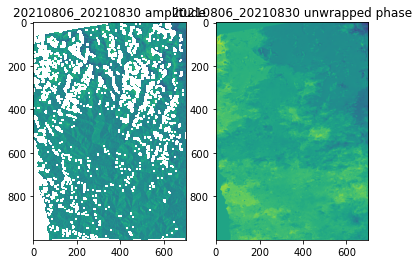

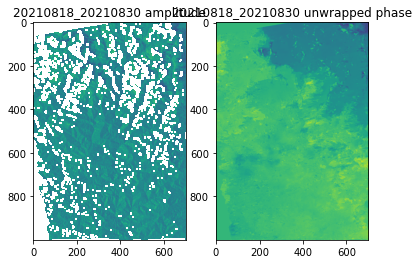

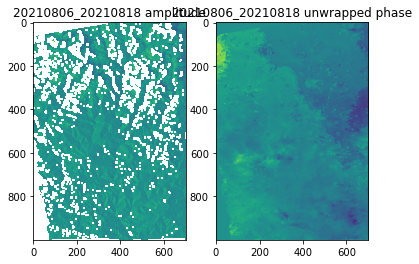

In [124]:
for i in int_list:
    os.chdir(f'/tmp/run_files/merged/interferograms/{i}')
    with rasterio.open('geo_filt_fine.unw.tif') as src:
        amp = src.read(1)
        phase = src.read(2)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(np.log(amp)); 
    ax[1].imshow(phase)
    ax[0].set_title(f'{i} amplitude')
    ax[1].set_title(f'{i} unwrapped phase')